# 2 Применение решающего дерева

Постройте решающее дерево из sklearn на датасете german credit data из UCI репозитория
и визуализируйте его. Попробуйте проинтерпретировать первые несколько разбиений, изучив описание признаков. Постройте графики зависимости качества на кросс-валидации и на
обучающей выборке от глубины дерева

In [2]:
from sklearn import model_selection, tree
import graphviz
import pandas as pd
import numpy as np
import re
import pydotplus 
from IPython.display import Image
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('german.data.txt', sep=' ', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


Из описания в german.doc находим названия признаков и значения категориальных переменных, выводим на экран таблицу в новом виде.

In [4]:
with open('german.doc') as f:
    description = f.readlines()
properties_names = []
properties = {}

description = map(lambda s: s.strip(), description)

for i in xrange(len(description)):
    if re.match('Attr?ibute \d+', description[i]):
        i += 1
        properties_names += [description[i]]
    match = re.match('(A\d+) : (.*)', description[i])
    if match:
        properties[match.group(1)] = match.group(2)
properties_names += ['Give credit']

In [5]:
data.columns = properties_names
data.replace(properties, inplace=True)
print 'Количество признаков =', len(data.columns) - 1
data.head()

Количество признаков = 20


,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Give credit
0,... < 0 DM,6,critical account/,radio/television,1169,unknown/ no savings account,.. >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,2
2,no checking account,12,critical account/,education,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,1
3,... < 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,if not A121 : building society savings agreement/,45,none,for free,1,skilled employee / official,2,none,yes,1
4,... < 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,2


Для того, чтобы построить решающеее дерево, нужно закодировать все категориальные признаки, что уже сделано в документе german-numeric.data.doc

In [6]:
with open('german_data-numeric.txt') as f:
    numeric_data = [map(int, line.strip().split()) for line in f.readlines()]
    
for i, x in enumerate(numeric_data):
    numeric_data[i] = np.array(x)
numeric_data = np.array(numeric_data)
numeric_data = pd.DataFrame(numeric_data)

In [7]:
numeric_data

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2
5,4,36,2,91,5,3,3,4,4,35,...,0,0,1,0,0,0,0,1,0,1
6,4,24,2,28,3,5,3,4,2,53,...,0,0,1,0,0,1,0,0,1,1
7,2,36,2,69,1,3,3,2,3,35,...,0,1,1,0,1,0,0,0,0,1
8,4,12,2,31,4,4,1,4,1,61,...,0,0,1,0,0,1,0,1,0,1
9,2,30,4,52,1,1,4,2,3,28,...,1,0,1,0,0,1,0,0,0,2


Приведем target переменную к привычному виду: от 1/2 -> 1/0, где 1 - выдавать кредит, 0 - не выдавать.

In [8]:
y = numeric_data.iloc[:, -1].apply(lambda x: 1 if x == 1 else 0)
X = numeric_data.iloc[:, :-1]

In [9]:
print 'Всего:'
print '{} объектов 1-го класса'.format((y==1).sum() * 1./len(y))
print '{} объектов 0-го класса'.format((y==0).sum() * 1./len(y))

Всего:
0.7 объектов 1-го класса
0.3 объектов 0-го класса


Строим с помощью sklearn дерево, максимальная глубина которого равна 2:

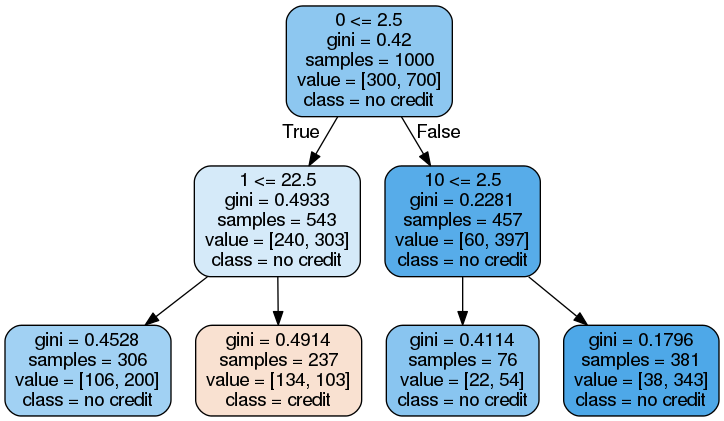

In [17]:
classifier = tree.DecisionTreeClassifier(max_depth=2)
classifier.fit(X, y)
dot_data = tree.export_graphviz(classifier, out_file="tree3.out", 
                         feature_names=X.columns,  
                         class_names=['credit', 'no credit'],  
                         filled=True, rounded=True,  
                         special_characters=False)  
graph = pydotplus.graphviz.graph_from_dot_file("tree3.out")  
Image(graph.create_png())  

То есть вначале разбиваем по размеру доходов и наличию счета.
Если доходы большие или счета нет, то, если других обязательств нет - выдаем, иначе не выдаем.
В противном случае выдаем краткосрочные кредиты (меньше 22.5 месяцев).

Без ограничения на глубину:

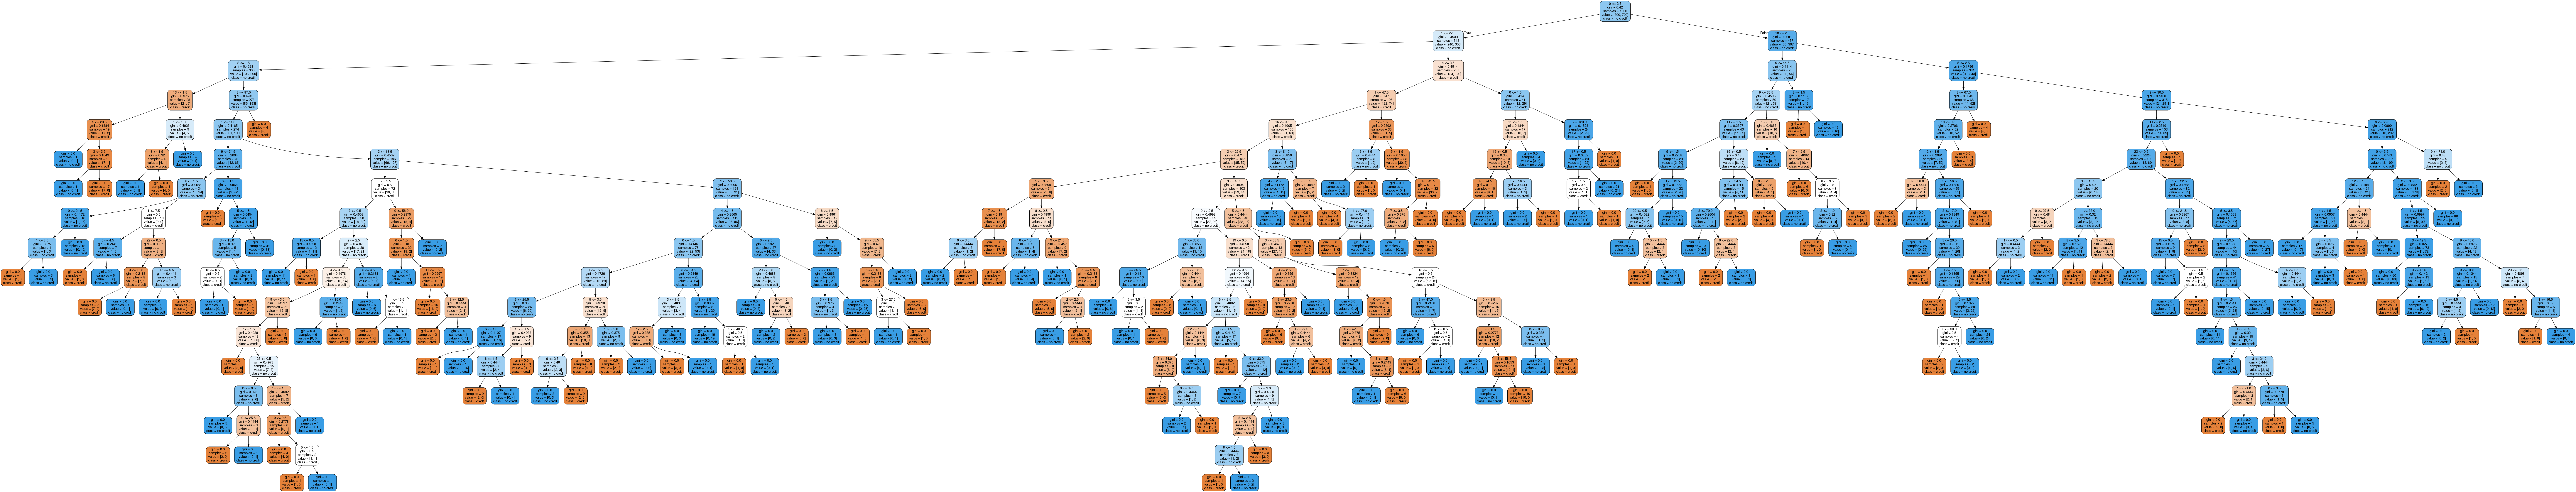

In [18]:
classifier = tree.DecisionTreeClassifier()
classifier.fit(X, y)
dot_data = tree.export_graphviz(classifier, out_file="tree.out", 
                         feature_names=X.columns,  
                         class_names=['credit', 'no credit'],  
                         filled=True, rounded=True,  
                         special_characters=False)  
graph = pydotplus.graphviz.graph_from_dot_file("tree.out")  
Image(graph.create_png())  

Теперь посмотрим на зависимость качества от глубины.

In [19]:
depths = np.arange(1, 30)
scores = []
train_score = []
X_train, y_train, X_test, y_test = model_selection.train_test_split(X, y, test_size=0.3)
for depth in depths:
    model = tree.DecisionTreeClassifier(max_depth=depth)
    scores += [model_selection.cross_val_score(model, X, y, scoring='roc_auc').mean()]
    model.fit(X, y)
    train_score += [metrics.roc_auc_score(y, model.predict(X))]

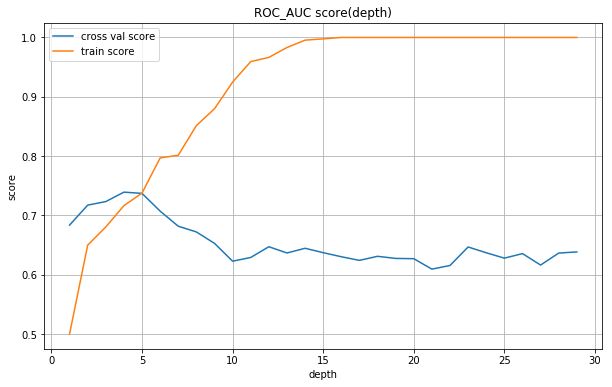

In [20]:
plt.figure(figsize=(10, 6))
plt.title('ROC_AUC score(depth)')
plt.plot(depths, scores, label='cross val score')
plt.plot(depths, train_score, label='train score')
plt.grid(True)
plt.xlabel('depth')
plt.ylabel('score')
plt.legend(loc='best')
plt.show()

In [21]:
print 'best depth =', np.argmax(scores) + 1

best depth = 4
